<a href="https://colab.research.google.com/github/Mithil-hub/DMBS-PROJECT/blob/main/BlackHouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files


uploaded = files.upload()


file_name = next(iter(uploaded))

print(f"Successfully uploaded file: {file_name}")

Saving SOUN_2025-04-03 00_00_00+00_00.csv to SOUN_2025-04-03 00_00_00+00_00.csv
Successfully uploaded file: SOUN_2025-04-03 00_00_00+00_00.csv


In [2]:
import pandas as pd


df = pd.read_csv(file_name)

print("Data loaded successfully into DataFrame.")
df.head()

Data loaded successfully into DataFrame.


,ts_event,ts_event.1,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
0,2025-04-03 13:30:00.005642878+00:00,2025-04-03 13:30:00.005642878+00:00,10,2,14993,A,B,1,7.88,100,...,84,28,3,7.79,8.07,15,29,5,1,SOUN
1,2025-04-03 13:30:00.005948702+00:00,2025-04-03 13:30:00.005948702+00:00,10,2,14993,A,A,1,7.92,100,...,84,28,3,7.79,8.07,15,29,5,1,SOUN
2,2025-04-03 13:30:00.013021640+00:00,2025-04-03 13:30:00.013021640+00:00,10,2,14993,C,A,0,7.91,84,...,84,28,3,7.79,8.07,15,29,5,1,SOUN
3,2025-04-03 13:30:00.015953598+00:00,2025-04-03 13:30:00.015953598+00:00,10,2,14993,A,A,1,7.92,100,...,84,28,3,7.79,8.07,15,29,5,1,SOUN
4,2025-04-03 13:30:00.016252285+00:00,2025-04-03 13:30:00.016252285+00:00,10,2,14993,T,A,0,7.89,20,...,84,28,3,7.79,8.07,15,29,5,1,SOUN


In [3]:
import numpy as np

def calculate_buy_slippage(order_size, row):

    mid_price = (row['bid_px_00'] + row['ask_px_00']) / 2

    shares_remaining = order_size
    total_cost = 0

    for i in range(10):
        price_level = row[f'ask_px_{i:02d}']
        available_shares = row[f'ask_sz_{i:02d}']


        shares_to_buy = min(shares_remaining, available_shares)

        total_cost += shares_to_buy * price_level
        shares_remaining -= shares_to_buy


        if shares_remaining == 0:
            break

    if shares_remaining > 0:
        return None

    avg_execution_price = total_cost / order_size


    slippage = avg_execution_price - mid_price
    return slippage

In [4]:

results = []


for index, row in df.sample(n=2000, random_state=42).iterrows():

    for size in range(10, 1001, 10):
        slippage = calculate_buy_slippage(size, row)

        if slippage is not None:
            results.append({'order_size': size, 'slippage': slippage})


model_df = pd.DataFrame(results)

print(f"Generated {len(model_df)} data points for modeling.")
print(model_df.head())

Generated 200000 data points for modeling.
   order_size  slippage
0          10     0.005
1          20     0.005
2          30     0.005
3          40     0.005
4          50     0.005


In [5]:
from scipy.optimize import curve_fit

def power_law(x, c, alpha):
    return c * np.power(x, alpha)

X_data = model_df['order_size']
y_data = model_df['slippage']

popt, pcov = curve_fit(power_law, X_data, y_data, p0=[0.001, 0.5])

c_fit, alpha_fit = popt

print("Model fitting complete.")
print(f"Fitted Power Law Model: g(x) = {c_fit:.6f} * x^{alpha_fit:.4f}")

Model fitting complete.
Fitted Power Law Model: g(x) = 0.003993 * x^0.0807


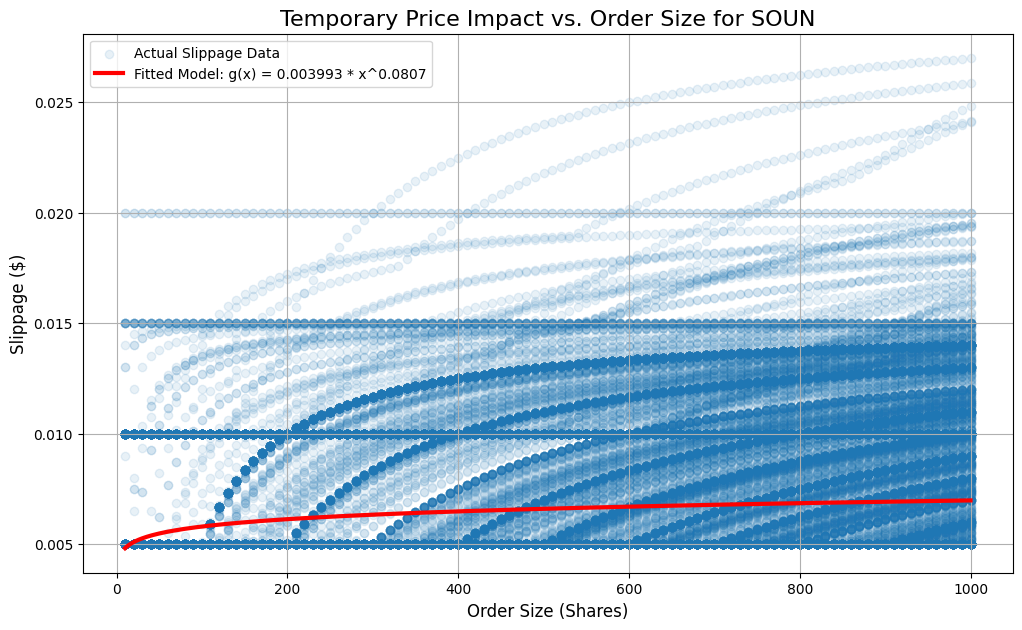

In [7]:
import matplotlib.pyplot as plt
x_fit = np.linspace(min(X_data), max(X_data), 500)
y_fit = power_law(x_fit, c_fit, alpha_fit)


plt.figure(figsize=(12, 7))


plt.scatter(X_data, y_data, alpha=0.1, label='Actual Slippage Data')

plt.plot(x_fit, y_fit, color='red', linewidth=3, label=f'Fitted Model: g(x) = {c_fit:.6f} * x^{alpha_fit:.4f}')

plt.title('Temporary Price Impact vs. Order Size for SOUN', fontsize=16)
plt.xlabel('Order Size (Shares)', fontsize=12)
plt.ylabel('Slippage ($)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

CRWV

CRWV data loaded. Shape: (189869, 74)
Generated 192404 data points for CRWV.
Fitted CRWV Model: g(x) = 0.008525 * x^0.4387


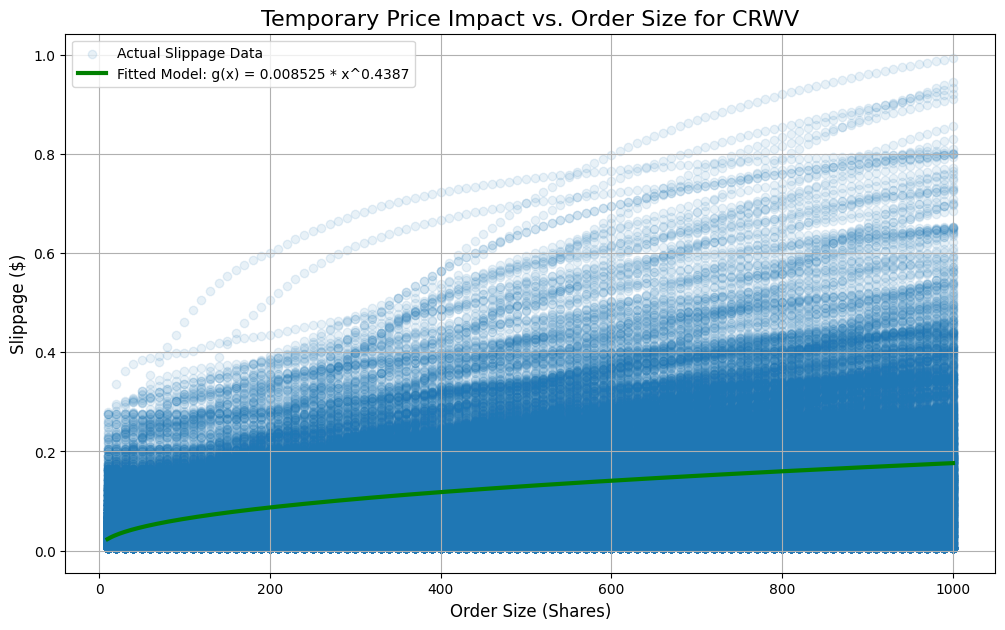

In [11]:

df_crwv = pd.read_csv('/content/CRWV_2025-04-03 00_00_00+00_00.csv')

bid_prices2 = [f'bid_px_{i:02d}' for i in range(10)]
ask_prices2 = [f'ask_px_{i:02d}' for i in range(10)]
bid_sizes2 = [f'bid_sz_{i:02d}' for i in range(10)]
ask_sizes2 = [f'ask_sz_{i:02d}' for i in range(10)]
df_crwv.dropna(subset=bid_prices2 + ask_prices2 + bid_sizes2 + ask_sizes2, inplace=True)
print(f"CRWV data loaded. Shape: {df_crwv.shape}")

results_crwv = []
for index, row in df_crwv.sample(n=2000, random_state=42).iterrows():
    for size in range(10, 1001, 10):
        slippage = calculate_buy_slippage(size, row)
        if slippage is not None:
            results_crwv.append({'order_size': size, 'slippage': slippage})
model_df_crwv = pd.DataFrame(results_crwv)
print(f"Generated {len(model_df_crwv)} data points for CRWV.")

X_data_crwv = model_df_crwv['order_size']
y_data_crwv = model_df_crwv['slippage']
popt_crwv, _ = curve_fit(power_law, X_data_crwv, y_data_crwv, p0=[0.001, 0.5])
c_fit_crwv, alpha_fit_crwv = popt_crwv
print(f"Fitted CRWV Model: g(x) = {c_fit_crwv:.6f} * x^{alpha_fit_crwv:.4f}")

x_fit_crwv = np.linspace(min(X_data_crwv), max(X_data_crwv), 500)
y_fit_crwv = power_law(x_fit_crwv, c_fit_crwv, alpha_fit_crwv)
plt.figure(figsize=(12, 7))
plt.scatter(X_data_crwv, y_data_crwv, alpha=0.1, label='Actual Slippage Data')
plt.plot(x_fit_crwv, y_fit_crwv, color='green', linewidth=3, label=f'Fitted Model: g(x) = {c_fit_crwv:.6f} * x^{alpha_fit_crwv:.4f}')
plt.title('Temporary Price Impact vs. Order Size for CRWV', fontsize=16)
plt.xlabel('Order Size (Shares)', fontsize=12)
plt.ylabel('Slippage ($)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

FROG

FROG data loaded. Shape: (33286, 74)
Generated 191777 data points for FROG.
Fitted FROG Model: g(x) = 0.010442 * x^0.2929


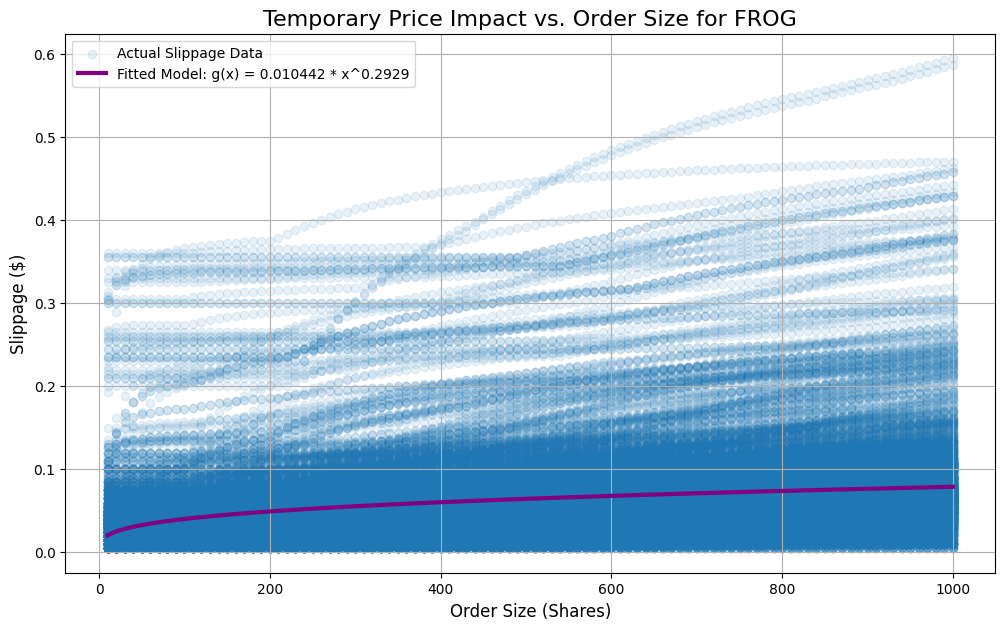

In [12]:


df_frog = pd.read_csv('/content/FROG_2025-04-03 00_00_00+00_00.csv')
bid_prices3 = [f'bid_px_{i:02d}' for i in range(10)]
ask_prices3 = [f'ask_px_{i:02d}' for i in range(10)]
bid_sizes3 = [f'bid_sz_{i:02d}' for i in range(10)]
ask_sizes3 = [f'ask_sz_{i:02d}' for i in range(10)]
df_frog.dropna(subset=bid_prices3 + ask_prices3 + bid_sizes3 + ask_sizes3, inplace=True)
print(f"FROG data loaded. Shape: {df_frog.shape}")

results_frog = []
for index, row in df_frog.sample(n=2000, random_state=42).iterrows():
    for size in range(10, 1001, 10):
        slippage = calculate_buy_slippage(size, row)
        if slippage is not None:
            results_frog.append({'order_size': size, 'slippage': slippage})
model_df_frog = pd.DataFrame(results_frog)
print(f"Generated {len(model_df_frog)} data points for FROG.")

X_data_frog = model_df_frog['order_size']
y_data_frog = model_df_frog['slippage']
popt_frog, _ = curve_fit(power_law, X_data_frog, y_data_frog, p0=[0.001, 0.5])
c_fit_frog, alpha_fit_frog = popt_frog
print(f"Fitted FROG Model: g(x) = {c_fit_frog:.6f} * x^{alpha_fit_frog:.4f}")

x_fit_frog = np.linspace(min(X_data_frog), max(X_data_frog), 500)
y_fit_frog = power_law(x_fit_frog, c_fit_frog, alpha_fit_frog)
plt.figure(figsize=(12, 7))
plt.scatter(X_data_frog, y_data_frog, alpha=0.1, label='Actual Slippage Data')
plt.plot(x_fit_frog, y_fit_frog, color='purple', linewidth=3, label=f'Fitted Model: g(x) = {c_fit_frog:.6f} * x^{alpha_fit_frog:.4f}')
plt.title('Temporary Price Impact vs. Order Size for FROG', fontsize=16)
plt.xlabel('Order Size (Shares)', fontsize=12)
plt.ylabel('Slippage ($)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()